<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/unsupervised/rbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
tf.random.set_seed(1)

In [215]:
print(tf.__version__)

2.1.0


In [0]:
class RBM:
    
  def __init__(self, input_size, hidden_size):
    
    self._input_size = input_size # Size of visible layer
    self._hidden_size = hidden_size # Size of hidden layer
          
    # Initialise weights to small random values
    self.w = tf.random.normal((input_size, hidden_size), stddev=0.01, dtype=np.float32)
    #self.w = tf.random.normal((input_size, hidden_size), 
    #                          stddev=2*np.sqrt(1/(input_size + hidden_size)), 
    #                          dtype=np.float32)
    self.hb = tf.zeros([hidden_size], np.float32)
    self.vb = tf.zeros([input_size], np.float32)

  def sample_prob(self, probs):
    return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

  def prob_h_given_v(self, v):
    return tf.nn.sigmoid(tf.matmul(v, self.w) + self.hb)

  def sample_h_given_v(self, v):
    prob = self.prob_h_given_v(v)
    return self.sample_prob(prob), prob

  def prob_v_given_h(self, h):
    return tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.w)) + self.vb)

  def sample_v_given_h(self, h):
    prob = self.prob_v_given_h(h)
    return self.sample_prob(prob), prob

Read in MNIST data, convert to binary units andf flatten

In [0]:
(train_data, _), (test_data, _) =  tf.keras.datasets.mnist.load_data()
train_data = np.round(train_data/ 255)
test_data = np.round(test_data/ 255)
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1] * train_data.shape[2])).astype(np.float32)
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1] * test_data.shape[2])).astype(np.float32)

In [0]:
BATCH_SIZE = 100

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(BATCH_SIZE).shuffle(10000)

In [0]:
input_size = train_data.shape[1]
rbm = RBM(input_size, 100)

In [0]:
EPOCHS = 10
LEARNING_RATE = 0.01

In [222]:
loss = []
for epoch in range(EPOCHS):
  err = 0
  for batch in dataset:
    # Perform CD-1
    h0, h0_prob = rbm.sample_h_given_v(batch)
    v1, v1_prob = rbm.sample_v_given_h(h0)
    h1, h1_prob = rbm.sample_h_given_v(v1)
    # Calculate gradients 
    positive_grad = tf.matmul(tf.transpose(batch), h0_prob)
    negative_grad = tf.matmul(tf.transpose(v1), h1_prob)
    #Update parameters
    rbm.w += LEARNING_RATE *(positive_grad - negative_grad) / BATCH_SIZE
    rbm.vb += LEARNING_RATE * tf.reduce_mean(batch - v1, 0)
    rbm.hb += LEARNING_RATE * tf.reduce_mean(h0 - h1, 0)
    #Find the reconstruction error
    err += tf.math.reduce_sum(tf.square(batch - v1))
  print ('Epoch: %d' % epoch,'reconstruction error: %f' % err)
  loss.append(err)      

Epoch: 0 reconstruction error: 9195681.000000
Epoch: 1 reconstruction error: 6537361.000000
Epoch: 2 reconstruction error: 5810751.000000
Epoch: 3 reconstruction error: 5392046.000000
Epoch: 4 reconstruction error: 5104972.000000
Epoch: 5 reconstruction error: 4882735.000000
Epoch: 6 reconstruction error: 4705222.000000
Epoch: 7 reconstruction error: 4553861.000000
Epoch: 8 reconstruction error: 4430806.000000
Epoch: 9 reconstruction error: 4321342.000000


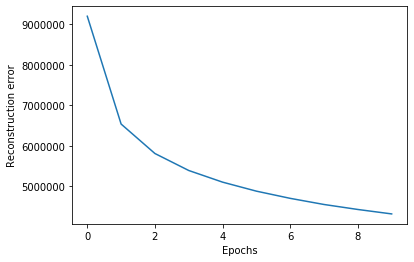

In [223]:
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

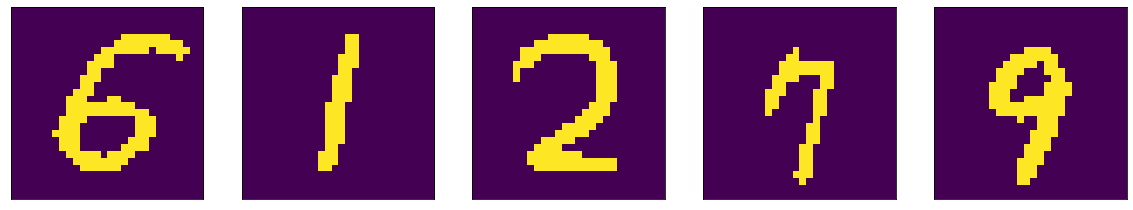

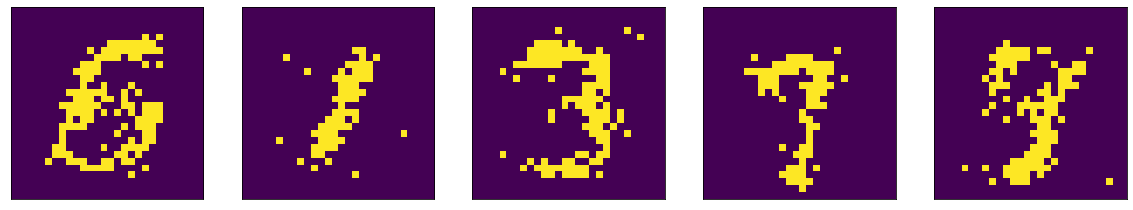

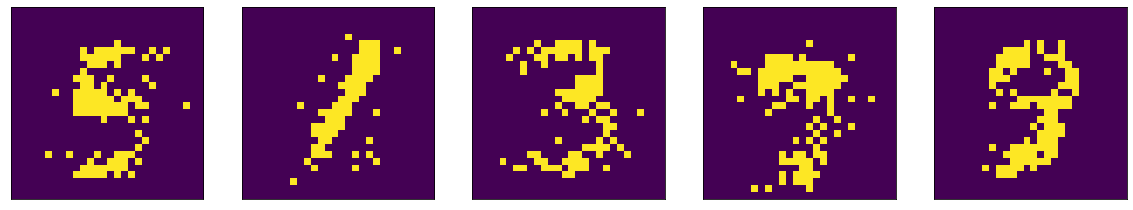

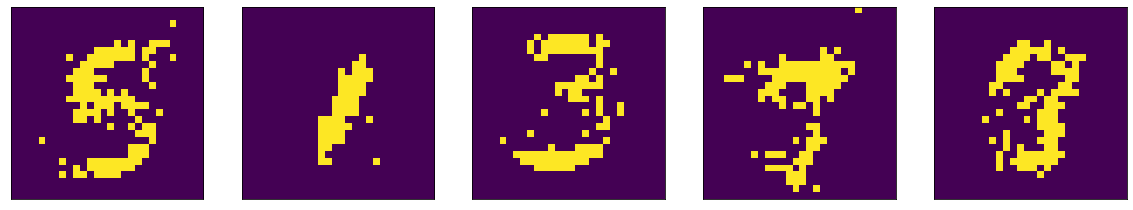

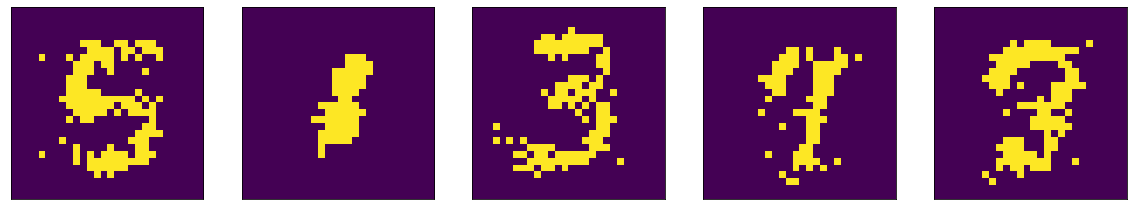

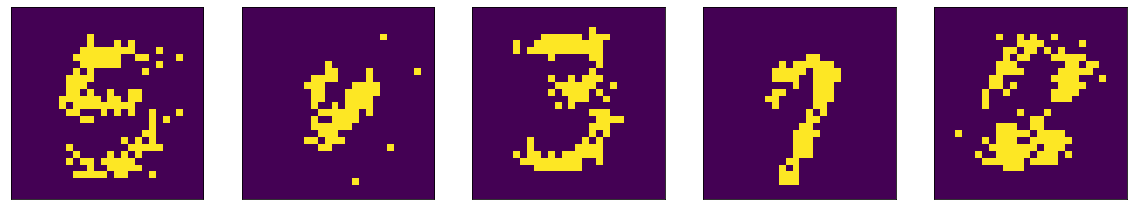

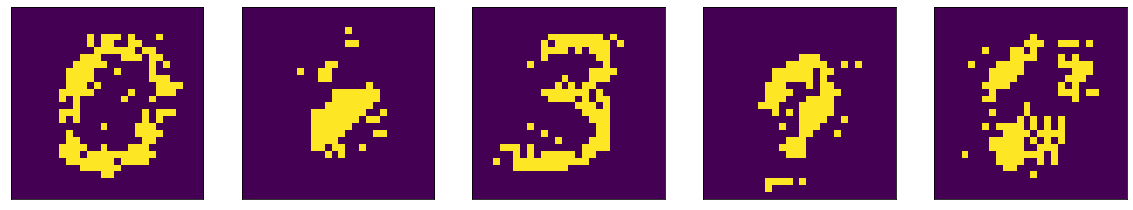

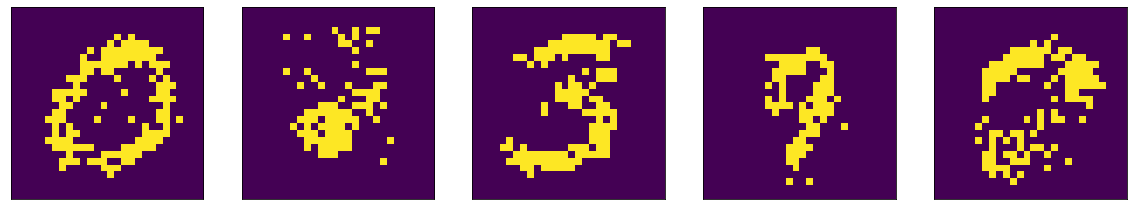

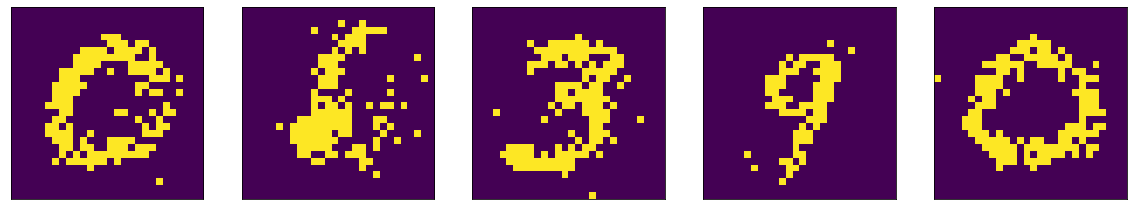

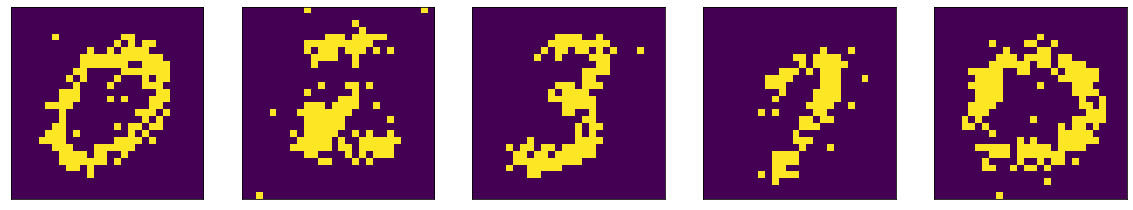

In [229]:
for v in dataset.take(1):
  for step in range(100):
    if step % 10 == 0:
      fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,4))  
      for i in range(5):
        axes[i].imshow(tf.reshape(v[i],[28, 28]))
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
      plt.show()
    h, _ = rbm.sample_h_given_v(v)
    v, _ = rbm.sample_v_given_h(h)